# EXTRACT MEDICINE INVOICES


## 1. Build graphs from text frame information

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt 
import math 
import itertools
# for making adjacency matrix
import networkx as nx

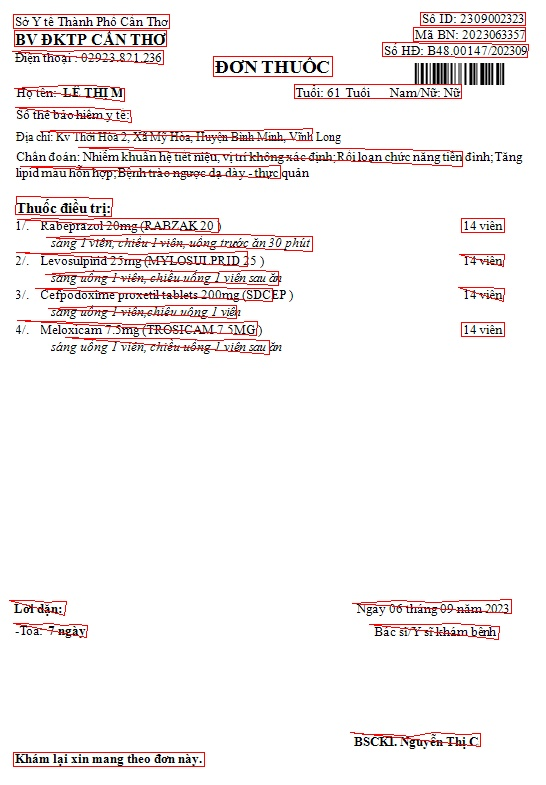

In [3]:
from PIL import Image

image = Image.open('D:\Luan Van\Project\med-scan-backend\Resultsres_1.jpg')
image

In [3]:
import cv2
import numpy as np
import pandas as pd
image = cv2.imread("D:/Luan Van/Project/med-scan-backend/Resultsres_1.jpg")
filename = 'output.csv'

#Preprocess data

filepath = 'D:/Luan Van/Project/med-scan-backend/results/'+filename
df = pd.read_csv(filepath, header=None, sep='\n')
df = df[0].str.split(',', expand=True)
temp = df.copy() 
temp[temp.columns] = temp.apply(lambda x: x.str.strip())
temp.fillna('', inplace=True)
temp[8]= temp[8].str.cat(temp.iloc[:,9:-1], sep =", ") 
temp[temp.columns] = temp.apply(lambda x: x.str.rstrip(", ,"))
temp = temp.loc[:, :8]
temp.drop([2,3,6,7], axis=1, inplace=True)
temp.columns = ['xmin','ymin','xmax','ymax','Object']
temp[['xmin','ymin','xmax','ymax']] = temp[['xmin','ymin','xmax','ymax']].apply(pd.to_numeric)

df = temp 
print(df)

ValueError: Specified \n as separator or delimiter. This forces the python engine which does not accept a line terminator. Hence it is not allowed to use the line terminator as separator.

In [4]:
image = cv2.imread("D:/Luan Van/Project/med-scan-backend/Resultsres_1.jpg")
filename = 'output.csv'

#Preprocess data

filepath = 'D:/Luan Van/Project/med-scan-backend/results/'+filename
df = pd.read_csv(filepath, header=None, sep='\t')
df = df[0].str.split(',', expand=True)
temp = df.copy() 
temp[temp.columns] = temp.apply(lambda x: x.str.strip())
temp.fillna('', inplace=True)
temp[8]= temp[8].str.cat(temp.iloc[:,9:-1], sep =", ") 
temp[temp.columns] = temp.apply(lambda x: x.str.rstrip(", ,"))
temp = temp.loc[:, :8]
temp.drop([2,3,6,7], axis=1, inplace=True)
temp.columns = ['xmin','ymin','xmax','ymax','Object']
temp[['xmin','ymin','xmax','ymax']] = temp[['xmin','ymin','xmax','ymax']].apply(pd.to_numeric)

df = temp 
print(df)

    xmin  ymin  xmax  ymax                                             Object
0     13    14   169    28                                  Số ID: 2309002323
1    413    27   525    41                          Sở Y tê Thành Phố Cần Thơ
2     14    30   166    46                                  Mã BN: 2023063357
3    382    42   527    57                                    BV ĐKTP CẦN THƠ
4     13    50   162    65                            Số HĐ: B48.00147/202309
5    213    56   332    76                          Điện thoại: 02923.821.236
6     14    84   122    98                                          ĐƠN THUỐC
7    294    84   461    98                                   Họ tên: lễ thị m
8     14   107   130   122                           Tuổi: 61 Tuổi Nam/Nữ: Nữ
9     14   127   342   145                               Số thể bảo hiếm y tế
10    14   147   523   166  "Kỳ Thơi Hòa 2, Xã M/Hòa Huyện Bình Minh Vĩnh ...
11    14   163   310   183   "Nhiềm khuân hệ tiết niệu, vị trí k

In [5]:
image_height, image_width = image.shape[0], image.shape[1]

__Line formation:__

This ensures that words are read from top left corner of the image first, 
going line by line from left to right and at last the final bottom right word of the page is read.




In [12]:
#sort df by 'top' coordinate. 
def line_formation(boundingbox_df):
    """
    args: 
        df with words and cordinates (xmin,xmax,ymin,ymax)
    returns: 
        df with words arranged in orientation top to bottom and left to right

    """
    assert type(df) == pd.DataFrame,f'object_map should be of type \
        {pd.DataFrame}. Received {type(boundingbox_df)}'
    assert type(image) == np.ndarray,f'image should be of type {np.ndarray} \
        . Received {type(image)}'

    assert 'xmin' in boundingbox_df.columns, '"xmin" not in object map'
    assert 'xmax' in boundingbox_df.columns, '"xmax" not in object map'
    assert 'ymin' in boundingbox_df.columns, '"ymin" not in object map'
    assert 'ymax' in boundingbox_df.columns, '"ymax" not in object map'
    assert 'Object' in boundingbox_df.columns, '"Object" column not in object map'
    #remove empty spaces both in front and behind
    df.columns = df.columns.str.strip()

    #further cleaning
    df.dropna(inplace=True)
    #sort from top to bottom
    df.sort_values(by=['ymin'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    #subtracting ymax by 1 to eliminate ambiguity of boxes being in both left and right 
    df["ymax"] = df["ymax"].apply(lambda x: x - 1)



 
    """

    _______________y axis__________
    |
    |                       top    
    x axis               ___________________
    |              left | bounding box      |  right
    |                   |___________________|           
    |                       bottom 
    |
    |


    iterate through the rows twice to compare them.
    remember that the axes are inverted.
    """
    master = []
    for idx, row in df.iterrows():

        #flatten the nested list 
        flat_master = list(itertools.chain(*master))
        #print(flat_master)
        #check to see if idx is in flat_master
        if idx not in flat_master:
            top_a = row['ymin']
            bottom_a = row['ymax']
            #top, bottom, right, left
            #coordinates = (row['ymin'],row['ymax'],row['xmin'],row['xmax'])
            #print(coordinates)

            #line will atleast have the word in it
            line = [idx]
            #line1=[row['Object']]
        
            for idx_2, row_2 in df.iterrows():
                #check to see if idx_2 is in flat_master removes ambiguity
                #picks higher cordinate one. 
                if idx_2 not in flat_master:
                #if not the same words
                    if not idx == idx_2:
                        top_b = row_2['ymin']
                        bottom_b = row_2['ymax'] 
                        if (top_a <= bottom_b) and (bottom_a >= top_b): 
                            line.append(idx_2)
                            #print(line)
            master.append(line)



    df2 = pd.DataFrame({'words_indices': master, 'line_number':[x for x in range(1,len(master)+1)]})

    #explode the list columns eg : [1,2,3]
    df2 = df2.set_index('line_number').words_indices.apply(pd.Series).stack()\
            .reset_index(level=0).rename(columns={0:'words_indices'})

    df2['words_indices'] = df2['words_indices'].astype('int')

    
    #put the line numbers back to the list
    # final = df.merge(df2, left_on=df.index, right_on='words_indices')
    final = df.reset_index().merge(df2, left_on='index', right_on='words_indices')


    final.drop('words_indices', axis=1, inplace=True)
    
    
    """
    3) Sort words in each line based on Left coordinate
    """
    final2 =final.sort_values(by=['line_number','xmin'],ascending=True)\
            .groupby('line_number')\
            .head(len(final))\
            .reset_index(drop=True)


    return final2
    
line_formation(df)



,index,xmin,ymin,xmax,ymax,Object,line_number
0,0,13,14,169,22,Số ID: 2309002323,1
1,2,14,30,166,40,Mã BN: 2023063357,2
2,1,413,27,525,35,Sở Y tê Thành Phố Cần Thơ,2
3,4,13,50,162,59,Số HĐ: B48.00147/202309,3
4,3,382,42,527,51,BV ĐKTP CẦN THƠ,3
5,5,213,56,332,70,Điện thoại: 02923.821.236,4
6,6,14,84,122,92,ĐƠN THUỐC,5
7,7,294,84,461,92,Họ tên: lễ thị m,5
8,8,14,107,130,116,Tuổi: 61 Tuổi Nam/Nữ: Nữ,6
9,9,14,127,342,139,Số thể bảo hiếm y tế,7


In [13]:
line_formation(df)

,index,xmin,ymin,xmax,ymax,Object,line_number
0,0,13,14,169,21,Số ID: 2309002323,1
1,2,14,30,166,39,Mã BN: 2023063357,2
2,1,413,27,525,34,Sở Y tê Thành Phố Cần Thơ,2
3,4,13,50,162,58,Số HĐ: B48.00147/202309,3
4,3,382,42,527,50,BV ĐKTP CẦN THƠ,3
5,5,213,56,332,69,Điện thoại: 02923.821.236,4
6,6,14,84,122,91,ĐƠN THUỐC,5
7,7,294,84,461,91,Họ tên: lễ thị m,5
8,8,14,107,130,115,Tuổi: 61 Tuổi Nam/Nữ: Nữ,6
9,9,14,127,342,138,Số thể bảo hiếm y tế,7


__Graph Formation__

For each word, perform the following:<br>
    - Check words which are in vertical projection with it.<br>
    - Calculate RD_l and RD_r for each of them <br>
    - Select nearest neighbour words in horizontal direction which have least magnitude of RD_l and RD_r,provided that those words do not have an edge in that direciton.<br>
    - In case, two words have same RD_l or RD_r, the word having higher top coordinate is chosen.<br>
    - Repeat steps from 2.1 to 2.3 similarly for retrieving nearest neighbour words in vertical direction by taking horizontal projection, calculating RD_t and RD_b and choosing words having higher left co-ordinate incase of ambiguity.<br>
    - Draw edges between word and its 4 nearest neighbours if they are available.<br>

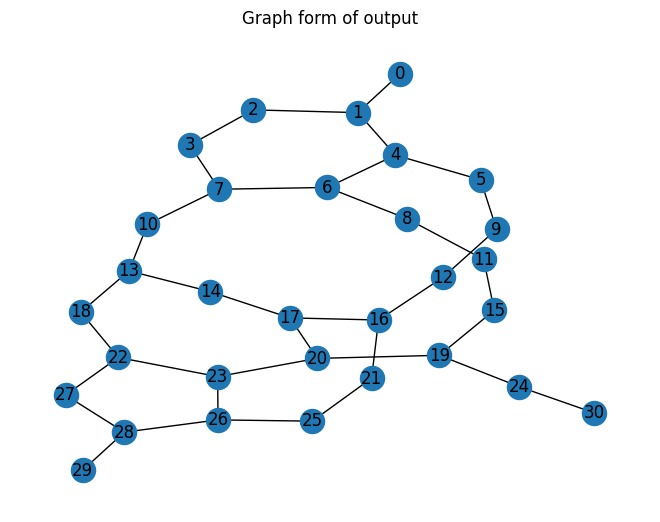

In [14]:
df = line_formation(df)


def grapher(df, export_graph =False):

    #horizontal edges formation
    #print(df)
    df.reset_index(inplace=True)
            
    
   
    grouped = df.groupby('line_number')
    
    #for undirected graph construction
    horizontal_connections = {}

    #left
    left_connections = {}    

    #right
    right_connections = {}

    for _,group in grouped:
        a = group['index'].tolist()
        b = group['index'].tolist()
        #b.reverse()
        #a = 0,1,2
        #2
        horizontal_connection = {a[i]:a[i+1] for i in range(len(a)-1) }

        #storing directional connections
        right_dict_temp = {a[i]:{'right':a[i+1]} for i in range(len(a)-1) }
        left_dict_temp = {b[i+1]:{'left':b[i]} for i in range(len(b)-1) }


        #add the indices in the dataframes
        for i in range(len(a)-1):
           df.loc[df['index'] == a[i], 'right'] = int(a[i+1])
           df.loc[df['index'] == a[i+1], 'left'] = int(a[i])
    
        left_connections.update(right_dict_temp)
        right_connections.update(left_dict_temp)
        horizontal_connections.update(horizontal_connection)


    dic1,dic2 = left_connections, right_connections
    
 
    
    #verticle connections formation


    bottom_connections = {}
    top_connections = {}

    for idx, row in df.iterrows():
        if idx not in bottom_connections.keys():
  
            right_a = row['xmax']
            left_a = row['xmin']

            for idx_2, row_2 in df.iterrows():

                #check for higher idx values 
             
                if idx_2 not in bottom_connections.values() and idx < idx_2:
                    #if idx_2 not in bottom_connections.values() and (idx != idx_2):
                        right_b = row_2['xmax']
                        left_b = row_2['xmin'] 
                        if (left_b <= right_a) and (right_b >= left_a): 
                            bottom_connections[idx] = idx_2
                            
                            top_connections[idx_2] = idx

                            #add it to the dataframe
                            df.loc[df['index'] == idx , 'bottom'] = idx_2
                            df.loc[df['index'] == idx_2, 'top'] = idx 

                            #print(bottom_connections)

                            #once the condition is met, break the loop to reduce redundant time complexity
                            break 
                    
                            #below = True 

    # print(df)


    # print('bottom connections:', bottom_connections)
    # # print(top_connections)
    # print('horizontal connections:', horizontal_connections)


    #combining both 
    result = {}
    dic1 = horizontal_connections
    dic2 = bottom_connections

    for key in (dic1.keys() | dic2.keys()):
        if key in dic1: result.setdefault(key, []).append(dic1[key])
        if key in dic2: result.setdefault(key, []).append(dic2[key])
    #print(result)

    G = nx.from_dict_of_lists(result)
  

    if export_graph:
        file, _ = os.path.splitext(filename)
        plot_path ='D:/Luan Van/Project/med-scan-backend/GCN/figures' + file + 'plain_graph' '.jpg'
        if not os.path.exists(plot_path):
            layout = nx.kamada_kawai_layout(G)        
            nx.draw(G, layout, with_labels=True)
           # plt.savefig(plot_path, format="PNG")
            plt.title(f'Graph form of {file}')
            plt.show()
            
        

    return result, G, df 



#features calculation

dict_graph, graph, processed_df = grapher(df, export_graph=True)

In [15]:
dict_graph 

{0: [1],
 1: [4],
 2: [1, 3],
 3: [7],
 4: [5, 6],
 5: [9],
 6: [7, 8],
 7: [10],
 8: [11],
 9: [12],
 10: [13],
 11: [15],
 12: [16],
 13: [14, 18],
 14: [17],
 15: [19],
 16: [17, 21],
 17: [20],
 18: [22],
 19: [20, 24],
 20: [23],
 21: [25],
 22: [23, 27],
 23: [26],
 24: [30],
 25: [26],
 26: [28],
 28: [27, 29]}

In [32]:
graph

In [33]:
processed_df


,level_0,index,xmin,ymin,xmax,ymax,Object,line_number,right,left,bottom,top,rd_b,rd_r,rd_l,rd_t
0,0,0,13,14,169,20,Số ID: 2309002323,1,NaN,NaN,1.0,NaN,0.008917,0.000000,0.000000,0.000000
1,1,2,14,30,166,38,Mã BN: 2023063357,2,1.0,NaN,3.0,NaN,0.005096,0.452381,0.000000,0.000000
2,2,1,413,27,525,33,Sở Y tê Thành Phố Cần Thơ,2,NaN,2.0,4.0,0.0,0.021656,0.000000,-0.452381,-0.008917
3,3,3,382,42,527,49,BV ĐKTP CẦN THƠ,3,NaN,NaN,7.0,2.0,0.044586,0.000000,0.000000,-0.005096
4,4,4,13,50,162,57,Số HĐ: B48.00147/202309,4,5.0,NaN,6.0,1.0,0.034395,0.093407,0.000000,-0.021656
5,5,5,213,56,332,68,Điện thoại: 02923.821.236,4,NaN,4.0,9.0,NaN,0.075159,0.000000,-0.093407,0.000000
6,6,6,14,84,122,90,ĐƠN THUỐC,5,7.0,NaN,8.0,4.0,0.021656,0.315018,0.000000,-0.034395
7,7,7,294,84,461,90,Họ tên: lễ thị m,5,NaN,6.0,10.0,3.0,0.072611,0.000000,-0.315018,-0.044586
8,8,8,14,107,130,114,Tuổi: 61 Tuổi Nam/Nữ: Nữ,6,NaN,NaN,11.0,6.0,0.062420,0.000000,0.000000,-0.021656
9,9,9,14,127,342,137,Số thể bảo hiếm y tế,7,NaN,NaN,12.0,5.0,0.075159,0.000000,0.000000,-0.075159


In [34]:
def relative_distance(df):
    #RDL and RDT are negative while RDR and RDB are positive
    plot_df = df.copy() 


    for index in df['index'].to_list():

        right_index = df.loc[df['index'] == index, 'right'].values[0]
        left_index = df.loc[df['index'] == index, 'left'].values[0]
        bottom_index = df.loc[df['index'] == index, 'bottom'].values[0]
        top_index = df.loc[df['index'] == index, 'top'].values[0]

        #rd_r = (right_word_xmin - left_word_xmax)/image_width

        #check if it is nan value 
        if np.isnan(right_index) == False: 
            right_word_left = df.loc[df['index'] == right_index, 'xmin'].values[0]
            source_word_right = df.loc[df['index'] == index, 'xmax'].values[0]

            df.loc[df['index'] == index, 'rd_r'] = (right_word_left - source_word_right)/image_width

            """
            for plotting purposes
            getting the mid point of the values to draw the lines for the graph
            mid points of source and destination for the bounding boxes
            """

            right_word_x_max = df.loc[df['index'] == right_index, 'xmax'].values[0]
            right_word_y_max = df.loc[df['index'] == right_index, 'ymax'].values[0]
            right_word_y_min = df.loc[df['index'] == right_index, 'ymin'].values[0]

            #source_word_x_min = df.loc[df['index'] == index, 'xmin'].values[0]

            #source_word_y_min = df.loc[df['index'] == index, 'xmin'].values[0]
            #source_word_y_min = df.loc[df['index'] == index, 'xmin'].values[0]



            plot_df.loc[df['index'] == index, 'destination_x_hori'] = (right_word_x_max + right_word_left)/2
            plot_df.loc[df['index'] == index, 'destination_y_hori'] = (right_word_y_max + right_word_y_min)/2
            #plot_df.loc[df['index'] == index, 'source_x_hori'] = (source_word_right - source_word_x_min)/2
            #plot_df.loc[df['index'] == index, 'source_y_hori'] = (source_word_right - source_word_min)/2



        if np.isnan(left_index) == False:
            left_word_right = df.loc[df['index'] == left_index, 'xmax'].values[0]
            source_word_left = df.loc[df['index'] == index, 'xmin'].values[0]

            df.loc[df['index'] == index, 'rd_l'] = (left_word_right - source_word_left)/image_width
        


        if np.isnan(bottom_index) == False:
            bottom_word_top = df.loc[df['index'] == bottom_index, 'ymin'].values[0]
            source_word_bottom = df.loc[df['index'] == index, 'ymax'].values[0]

            df.loc[df['index'] == index, 'rd_b'] = (bottom_word_top - source_word_bottom)/image_height


            #for plotting purposes
            bottom_word_top_max = df.loc[df['index'] == bottom_index, 'ymax'].values[0]
            #source_word_min = df.loc[df['index'] == index, 'ymin'].values[0]
            bottom_word_x_max = df.loc[df['index'] == bottom_index, 'xmax'].values[0]
            bottom_word_x_min = df.loc[df['index'] == bottom_index, 'xmin'].values[0]


            plot_df.loc[df['index'] == index, 'destination_y_vert'] = (bottom_word_top_max + bottom_word_top)/2
            plot_df.loc[df['index'] == index, 'destination_x_vert'] = (bottom_word_x_max + bottom_word_x_min)/2
            #plot_df.loc[df['index'] == index, 'source_y_vert'] = (source_word_bottom - source_word_min)/2


        if np.isnan(top_index) == False:
            top_word_bottom = df.loc[df['index'] == top_index, 'ymax'].values[0]
            source_word_top = df.loc[df['index'] == index, 'ymin'].values[0]

            df.loc[df['index'] == index, 'rd_t'] = (top_word_bottom - source_word_top)/image_height


    #replace all tne NaN values with '0' meaning there is nothing in that direction
    df[['rd_r','rd_b','rd_l','rd_t']] = df[['rd_r','rd_b','rd_l','rd_t']].fillna(0)
    

    plot_df['rd_r'] = df['rd_r']
    plot_df['rd_b'] = df['rd_b']
  
    return df, plot_df 


In [36]:
df, plot_df = relative_distance(processed_df)
print(plot_df)

    level_0  index  xmin  ymin  xmax  ymax  \
0         0      0    13    14   169    20   
1         1      2    14    30   166    38   
2         2      1   413    27   525    33   
3         3      3   382    42   527    49   
4         4      4    13    50   162    57   
5         5      5   213    56   332    68   
6         6      6    14    84   122    90   
7         7      7   294    84   461    90   
8         8      8    14   107   130   114   
9         9      9    14   127   342   137   
10       10     10    14   147   523   158   
11       11     11    14   163   310   175   
12       12     12    16   196   111   208   
13       13     13    14   218   222   226   
14       14     14   461   218   504   224   
15       15     15    49   234   311   242   
16       16     16    14   253   265   261   
17       17     17   461   254   504   258   
18       18     18    49   269   284   278   
19       19     19    13   288   293   294   
20       20     20   461   288   5

In [38]:
def show_document_graph(plot_df, img, export_image=False):
    for idx, row in plot_df.iterrows():
        #bounding box
        cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 0, 255), 2)

        if np.isnan(row['destination_x_vert']) == False:
            source_x = (row['xmax'] + row['xmin'])/2
            source_y = (row['ymax'] + row['ymin'])/2
            

            cv2.line(img, 
                    (int(source_x), int(source_y)),
                    (int(row['destination_x_vert']), int(row['destination_y_vert'])), 
                    (0,255,0), 1)


            text = "{:.3f}".format(row['rd_b'])
            text_coordinates = ( int((row['destination_x_vert'] + source_x)/2) , int((row['destination_y_vert'] +source_y)/2))     
            cv2.putText(img, text, text_coordinates, cv2.FONT_HERSHEY_DUPLEX, 0.4, (255,0,0), 1)

            #text_coordinates = ((row['destination_x_vert'] + source_x)/2 , (row['destination_y_vert'] +source_y)/2)
        
        if np.isnan(row['destination_x_hori']) == False:
            source_x = (row['xmax'] + row['xmin'])/2
            source_y = (row['ymax'] + row['ymin'])/2

            cv2.line(img, 
                (int(source_x), int(source_y)),
                (int(row['destination_x_hori']), int(row['destination_y_hori'])), \
                (0,255,0), 1)

            text = "{:.3f}".format(row['rd_r'])
            text_coordinates = (int((row['destination_x_hori'] + source_x)/2) , int((row['destination_y_hori'] +source_y)/2))     
            cv2.putText(img, text, text_coordinates, cv2.FONT_HERSHEY_DUPLEX, 0.4, (255,0,0), 1)

        


    # cv2.imshow("image", img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    if export_image:
        file, _ = os.path.splitext(filename)
        plot_path ='D:/Luan Van/Project/med-scan-backend/GCN/figures/' + file + 'docu_graph' '.jpg'
        if not os.path.exists(plot_path):
            cv2.imwrite(plot_path, img)
            

  

print(dict_graph)

show_document_graph(plot_df,image, export_image=True)

{0: [1], 1: [4], 2: [1, 3], 3: [7], 4: [5, 6], 5: [9], 6: [7, 8], 7: [10], 8: [11], 9: [12], 10: [13], 11: [15], 12: [16], 13: [14, 18], 14: [17], 15: [19], 16: [17, 21], 17: [20], 18: [22], 19: [20, 24], 20: [23], 21: [25], 22: [23, 27], 23: [26], 24: [30], 25: [26], 26: [28], 28: [27, 29]}


In [26]:

def make_adjacency(graph_dict):#, text_list):
    '''
        Function to make an adjacency matrix from a networkx graph object
        as well as padded feature matrix
        Args:
            G: networkx graph object
            
            text_list: list,
                        of text entities:
                        ['Tax Invoice', '1/2/2019', ...]
        Returns:
            A: Adjacency matrix as np.array
            X: Feature matrix as numpy array for input graph
    '''
    G = nx.from_dict_of_lists(graph_dict)
    adj_sparse = nx.adjacency_matrix(G)

    # preprocess the sparse adjacency matrix returned by networkx function
    A = np.array(adj_sparse.todense())
    #A = self._pad_adj(A)

    # preprocess the list of text entities
    #feat_list = list(map(self._get_text_features, text_list))
    #feat_arr = np.array(feat_list)
    #X = self._pad_text_features(feat_arr)

    return A

adjacancy_matrix = make_adjacency(dict_graph)

In [27]:
adjacancy_matrix

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [28]:
adjacancy_matrix.shape

(31, 31)

In [44]:


def is_alpha(text):
    return text.isalpha()

def is_lower(text):
    return text.islower()

def is_upper(text):
    return text.isupper()

def is_numeric(text):
    return text.isnumeric()

def is_space(text):
    return text.isspace()

def has_special_chars(text):
    special_chars = set(" !\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~")
    return any(char in special_chars for char in text)

def calculate_text_features(text, text_list):
    # Initialize a list to store feature values for the current text
    features = []

    # Add boolean features
    features.append(is_alpha(text['text']))
    features.append(is_lower(text['text']))
    features.append(is_upper(text['text']))
    features.append(is_numeric(text['text']))
    features.append(is_space(text['text']))
    features.append(has_special_chars(text['text']))

    # Add numeric features based on relative distances
    # You can calculate the distances from text_list using their coordinates
    for other_text in text_list:
        # Calculate the horizontal and vertical relative distances
        # and add them to the features
        horizontal_distance = abs(text['x'] - other_text['x'])
        vertical_distance = abs(text['y'] - other_text['y'])
        features.append(horizontal_distance)
        features.append(vertical_distance)

    # Additional text-based features (using DistilBERT or other models)
    # You can use pre-trained NLP models for text embedding
    # to generate a 768-D feature vector for each text element
    # Example:
    # text_embedding = generate_text_embedding(text)
    # features.extend(text_embedding)

    return features

# Example list of text elements with their properties
text_list = [
    {'text': 'Số ID: 2309002323', 'x': 13, 'y': 14},
    {'text': 'Sở Y tế Thành Phố Cần Thơ', 'x': 413, 'y': 27},
    {'text': 'Mã BN: 2023063357', 'x': 14, 'y': 30},
    {'text': 'BV ĐKTP CẦN THƠ', 'x': 382, 'y': 42},
    {'text': 'Số HĐ: B48.00147/202309', 'x': 13, 'y': 50},
    {'text': 'Điện thoại: 02923.821.236', 'x': 213, 'y': 56},
    {'text': 'ĐƠN THUỐC', 'x': 14, 'y': 84},
    {'text': 'Họ tên: lễ thị m', 'x': 294, 'y': 84},
    {'text': 'Tuổi: 61 Tuổi Nam/Nữ: Nữ', 'x': 14, 'y': 107},
    {'text': 'Số thể bảo hiểm y tế', 'x': 14, 'y': 127},
    {'text': 'Kỳ Thơi Hòa 2, Xã M/Hòa Huyện Bình Minh Vĩnh Thị Nam', 'x': 14, 'y': 147},
    {'text': 'Nhiềm khuân hệ tiết niệu, vị trí không xác định, Rối loan chức năng tiền', 'x': 14, 'y': 163},
    {'text': 'Thipid mau hồn hợp Bệnh trào ngược dạ dày - thực', 'x': 16, 'y': 196},
    {'text': 'Thuốc điều trị;', 'x': 14, 'y': 218},
    {'text': '17 Rabeprazo1 20mg (RABZAK 20', 'x': 461, 'y': 218},
    {'text': '14 viên', 'x': 49, 'y': 234},
    {'text': 'sang 1 viên, chiều 1 viên uồng trước ăn 30 phút', 'x': 14, 'y': 253},
    {'text': '2/2/ Levosupind 25mg (MYLOSULPRID', 'x': 461, 'y': 254},
    {'text': '14 viên', 'x': 49, 'y': 269},
    {'text': 'sang uông 1 viên, chiếu vống lyiên sau ă', 'x': 13, 'y': 288},
    {'text': 'Cefpodoxime proxetil tablets 200mg (SDC', 'x': 461, 'y': 288},
    {'text': '14 viên', 'x': 49, 'y': 304},
    {'text': 'sáng ường - viên,chiêu vông l viên', 'x': 14, 'y': 322},
    {'text': '4/ Meloxicam 7.5mg (TROSICAM 75MG', 'x': 461, 'y': 322},
    {'text': '14 viên', 'x': 49, 'y': 338},
    {'text': 'nguồng I viên, chiều uồng [viên sau', 'x': 12, 'y': 601},
    {'text': 'Lơi dặn', 'x': 354, 'y': 601},
    {'text': 'Ngày 06 tháng 09 năm 2023', 'x': 13, 'y': 624},
    {'text': 'Toa: 7-ngày', 'x': 372, 'y': 622},
    {'text': 'Bác sĩ Y sĩ khám bệnh', 'x': 351, 'y': 734},
    {'text': 'BSCKI. Nguyễn Thi', 'x': 13, 'y': 752}
]


# Initialize an empty list to store features for each text element
text_features_list = []

# Calculate features for each text element
for i, text_element in enumerate(text_list):
    # Get features for the current text element
    features = calculate_text_features(text_element, text_list)
    text_features_list.append(features)

# Convert the list of features into a NumPy array
text_features_matrix = np.array(text_features_list)

# Now, text_features_matrix contains the initial features for each text element in the graph.


In [45]:
print(text_features_matrix)


[[  0   0   0 ... 720   0 738]
 [  0   0   0 ... 707 400 725]
 [  0   0   0 ... 704   1 722]
 ...
 [  0   0   0 ... 112 359 130]
 [  0   0   0 ...   0 338  18]
 [  0   0   0 ...  18   0   0]]


In [46]:
# Get the number of text elements (frames)
num_text_elements = text_features_matrix.shape[0]

print("Number of text elements in the feature matrix:", num_text_elements)


Number of text elements in the feature matrix: 31
